# Library

In [1]:
#===========================================================
# Library
#===========================================================
import os
import gc
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from contextlib import contextmanager
import time

import numpy as np
import pandas as pd
import scipy as sp
import random

import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn import preprocessing
import category_encoders as ce
from sklearn.metrics import mean_squared_error

import torch

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# Utils

In [2]:
#===========================================================
# Utils
#===========================================================
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s')


def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    
def load_df(path, df_name, debug=False):
    if path.split('.')[-1]=='csv':
        df = pd.read_csv(path)
        if debug:
            df = pd.read_csv(path, nrows=1000)
    elif path.split('.')[-1]=='pkl':
        df = pd.read_pickle(path)
    if logger==None:
        print(f"{df_name} shape / {df.shape} ")
    else:
        logger.info(f"{df_name} shape / {df.shape} ")
    return df

# Config

In [3]:
#===========================================================
# Config
#===========================================================
OUTPUT_DICT = ''

ID = 'Id'
TARGET_COLS = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
SEED = 2020
seed_everything(seed=SEED)

N_FOLD = 15

# Data Loading

In [4]:
base_path = '/media/hiroki/share/kaggle_data/trends-assessment-prediction/'
train = pd.read_csv(base_path+'train_scores.csv', dtype={'Id':str})\
            #.dropna().reset_index(drop=True) # to make things easy
reveal_ID = pd.read_csv(base_path+'reveal_ID_site2.csv', dtype={'Id':str})
ICN_numbers = pd.read_csv(base_path+'ICN_numbers.csv')
loading = pd.read_csv(base_path+'loading.csv', dtype={'Id':str})
fnc = pd.read_csv(base_path+'fnc.csv', dtype={'Id':str})
sample_submission = pd.read_csv(base_path+'sample_submission.csv', dtype={'Id':str})

In [5]:
site_base_path = '/media/hiroki/working/kaggle/trends-neuroimaging/site_label/adversal/'
site_train = pd.read_csv(site_base_path+'/train_prob_site2_icapca.csv', dtype={'Id':str})
site_test = pd.read_csv(site_base_path+'/test_prob_site2_icapca.csv', dtype={'Id':str})

In [6]:
train.head()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421


In [7]:
reveal_ID.head()

,Id
0,10012
1,10014
2,10020
3,10034
4,10059


In [8]:
ICN_numbers.head()

,ICN_number
0,69
1,53
2,98
3,99
4,45


In [9]:
loading.head()

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
0,10001,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,...,0.018246,0.023711,0.009177,-0.013929,0.030696,0.010496,0.002892,-0.023235,0.022177,0.017192
1,10002,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,...,0.014635,0.022556,0.012004,-0.011814,0.022479,0.005739,0.002880,-0.016609,0.025543,0.014524
2,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
3,10004,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,...,0.002658,0.022266,0.005956,-0.010595,0.024078,-0.000319,0.005866,-0.015182,0.024476,0.014760
4,10005,-0.000398,0.006878,0.009051,0.000369,0.000336,0.010679,0.010352,0.003637,0.004180,...,0.009702,0.017257,0.005454,-0.008591,0.019416,0.000786,0.002692,-0.019814,0.017105,0.013316


In [10]:
fnc.head()

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,0.368580,0.166876,0.438148,0.341007,-0.186251,0.049096,0.121417,-0.174268,-0.231578,...,-0.149279,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488
1,10002,0.151696,-0.024819,0.217504,0.418072,-0.227234,-0.064052,-0.143832,-0.118116,-0.054825,...,-0.214216,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327
2,10003,0.343415,0.109974,0.741641,0.578558,-0.676446,-0.436960,-0.295663,-0.377790,-0.344963,...,-0.154941,0.136850,-0.022361,0.137625,0.677972,0.409412,0.563892,0.438684,0.618204,0.284474
3,10004,0.132793,0.258255,0.490769,0.342717,0.091112,0.107969,0.029220,-0.026237,0.094742,...,-0.130339,0.309540,0.141469,0.030853,0.344394,0.214097,0.317556,0.012435,0.665937,0.081358
4,10005,0.291921,0.251254,0.416470,0.511719,-0.362626,-0.164710,-0.289059,-0.015537,-0.087316,...,-0.139525,0.394932,0.040443,0.428334,0.498837,0.266755,0.227379,0.028984,0.752343,0.087898


In [11]:
sample_submission.head()

,Id,Predicted
0,10003_age,50.0
1,10003_domain1_var1,50.0
2,10003_domain1_var2,50.0
3,10003_domain2_var1,50.0
4,10003_domain2_var2,50.0


In [12]:
sample_submission['ID_num'] = sample_submission[ID].apply(lambda x: int(x.split('_')[0]))
test = pd.DataFrame({ID: sample_submission['ID_num'].unique().astype(str)})
del sample_submission['ID_num']; gc.collect()
test.head()

,Id
0,10003
1,10006
2,10010
3,10011
4,10012


# FE

In [13]:
train

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


In [14]:
#train.to_csv('add_ica_rep2_train.csv')
#test.to_csv('add_ica_rep2_test.csv')
train

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


In [15]:
decomp_base_path = '/media/hiroki/working/kaggle/trends-neuroimaging/tf_data'
ica_loading_pd = pd.read_csv(decomp_base_path+'/ica/loading_ica.csv', dtype={'Id':str})
pca_fnc_pd = pd.read_csv(decomp_base_path+'/pca/fnc_pca.csv', dtype={'Id':str})

In [16]:
site_train.drop(["is_site2", "is_site2_true"], axis=1, inplace=True)
site_test.drop(["is_site2", "is_site2_true"], axis=1, inplace=True)

In [17]:
# merge
train = train.merge(loading, on=ID, how='left')
train = train.merge(fnc, on=ID, how='left')
train = train.merge(ica_loading_pd, on=ID, how='left')
train = train.merge(pca_fnc_pd, on=ID, how='left')
train = train.merge(site_train, on=ID, how='left')

train.head()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,IC_01,IC_07,IC_05,IC_16,...,fnc_pc141,fnc_pc142,fnc_pc143,fnc_pc144,fnc_pc145,fnc_pc146,fnc_pc147,fnc_pc148,fnc_pc149,prob_site2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.006070,0.014466,0.004136,0.000658,...,0.219027,0.001179,-0.058451,-0.388662,-0.241710,-0.224239,0.056872,0.079370,-0.029729,0.234300
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.009087,0.009291,0.007049,-0.002076,...,-0.118583,-0.179065,-0.381546,-0.060484,-0.037991,-0.434464,0.299034,0.079064,-0.250063,0.256662
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,0.004675,0.000957,0.006154,-0.000429,...,-0.013931,-0.005913,0.202989,0.099073,0.028089,-0.011903,0.235919,-0.014796,-0.277931,0.340693
3,10005,66.532630,NaN,NaN,52.108977,69.993075,-0.000398,0.006878,0.009051,0.000369,...,-0.372342,0.207945,-0.128819,0.251851,-0.114924,0.014899,0.494779,-0.054188,-0.176513,0.334773
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.005192,0.010585,0.012160,-0.000920,...,-0.070015,0.154606,-0.153220,0.120113,-0.199256,-0.132451,0.268803,-0.344660,-0.295151,0.326972


In [18]:
# merge
#train = train.merge(pca_loading_pd, on=ID, how='left')
#train = train.merge(pca_fnc_pd, on=ID, how='left')
#train = train.merge(svd, on=ID, how='left')
#train.head()

In [19]:
# merge
test = test.merge(loading, on=ID, how='left')
test = test.merge(fnc, on=ID, how='left')
test = test.merge(ica_loading_pd, on=ID, how='left')
test = test.merge(pca_fnc_pd, on=ID, how='left')
test = test.merge(site_test, on=ID, how='left')


test.head()

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,fnc_pc141,fnc_pc142,fnc_pc143,fnc_pc144,fnc_pc145,fnc_pc146,fnc_pc147,fnc_pc148,fnc_pc149,prob_site2
0,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,-0.071504,0.190468,0.097928,-0.165759,0.202768,0.185363,-0.172570,0.180270,0.120484,0.359684
1,10006,0.000334,0.005311,0.010053,0.006920,-0.000065,0.015310,0.016543,0.004794,0.003982,...,0.051582,-0.014007,0.184597,0.160777,-0.119761,-0.015031,0.085200,-0.089972,-0.169212,0.352551
2,10010,0.007103,0.006144,0.009770,-0.002884,-0.001346,0.015651,0.011613,-0.003291,0.013423,...,-0.044116,-0.153219,-0.254180,-0.277504,0.185504,-0.079110,0.084088,0.078964,0.073566,0.349646
3,10011,0.004362,0.010240,0.010167,0.004492,-0.001623,0.017381,0.014680,0.007453,0.008786,...,0.205716,-0.131292,0.091335,0.414347,-0.060277,0.079852,-0.162485,-0.099584,0.134600,0.362414
4,10012,-0.007521,-0.003918,0.008434,-0.001145,0.002017,0.015065,0.019616,0.004140,-0.003744,...,-0.542525,-0.331014,0.130991,-0.024522,-0.317343,-0.363590,0.340918,0.335200,0.044452,0.374330


# Model

In [20]:
import numpy as np
import pandas as pd

import pickle as pkl

import gc
from sklearn.model_selection import KFold
from cuml.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns

In [21]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [22]:
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv_lgb(train_x, train_y, test_x, target_name, param):
    preds = []
    preds_test = []
    va_idxes = []
    
    score = []
    mae = []
    rmse = []
    
    features = train_x.columns
    # shuffleしなくても良い
    kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx].values, train_x.iloc[va_idx].values
        tr_y, va_y = train_y.iloc[tr_idx].values, train_y.iloc[va_idx].values
        
        lgb_train = lgb.Dataset(tr_x, tr_y)
        lgb_val = lgb.Dataset(va_x, va_y)
        
        num_round = 100000
        
        clf = lgb.train(param,
                       lgb_train,
                       num_round,
                       valid_sets=[lgb_train, lgb_val],
                       verbose_eval=False,
                       early_stopping_rounds=100)
        
        pred = clf.predict(va_x, num_iteration=clf.best_iteration)
        preds.append(pred)
        pred_test = clf.predict(test_x, num_iteration=clf.best_iteration)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)
        
        score.append(metric(va_y, pred))
        mae.append(mean_absolute_error(va_y, pred))
        rmse.append(np.sqrt(mean_squared_error(va_y, pred)))

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = i+1
        if i == 0:
            feature_importance_df = fold_importance_df
        else:
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    score_cv = np.array(score).mean()
    mae_cv = np.array(mae).mean()
    rmse_cv = np.array(rmse).mean()
    print("{0}_score:{1}".format(target_name, np.round(score_cv, 8)))
    print("{0}_mae:{1}".format(target_name, np.array(mae_cv).mean()))
    print("{0}_rmse:{1}".format(target_name, np.array(rmse_cv).mean()))
    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test, score_cv, feature_importance_df

In [23]:
lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             "learning_rate" : 0.01,
             "num_leaves" : 13,
             "bagging_freq": 5,
             "bagging_fraction" : 0.4,
             "feature_fraction" : 0.05,
             "min_sum_heassian_in_leaf": 10,
             "tree_learner": "serial",
             "boost_from_average": "false",
             "min_data_in_leaf": 80,
             "bagging_seed" : SEED,
             'seed': SEED,
             'max_depth': 3,
             "num_leaves" : 13,
             'verbosity': -1,
            }

In [24]:
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{name}_pca.png')

N_FOLD:15
-----age-----
age_score:0.14746747
age_mae:7.37740310129686
age_rmse:9.3425230347393
-----domain1_var1-----
domain1_var1_score:0.15189438
domain1_var1_mae:7.819066171649368
domain1_var1_rmse:9.73687208919332
-----domain1_var2-----
domain1_var2_score:0.15133374
domain1_var2_mae:8.963979137454283
domain1_var2_rmse:11.355973328634121
-----domain2_var1-----
domain2_var1_score:0.18288807
domain2_var1_mae:8.652805341513243
domain2_var1_rmse:10.924715355094566
-----domain2_var2-----
domain2_var2_score:0.1768609
domain2_var2_mae:9.176726082394334
domain2_var2_rmse:11.686497168367364
--------------------------------------------
Overal score: 0.16026123


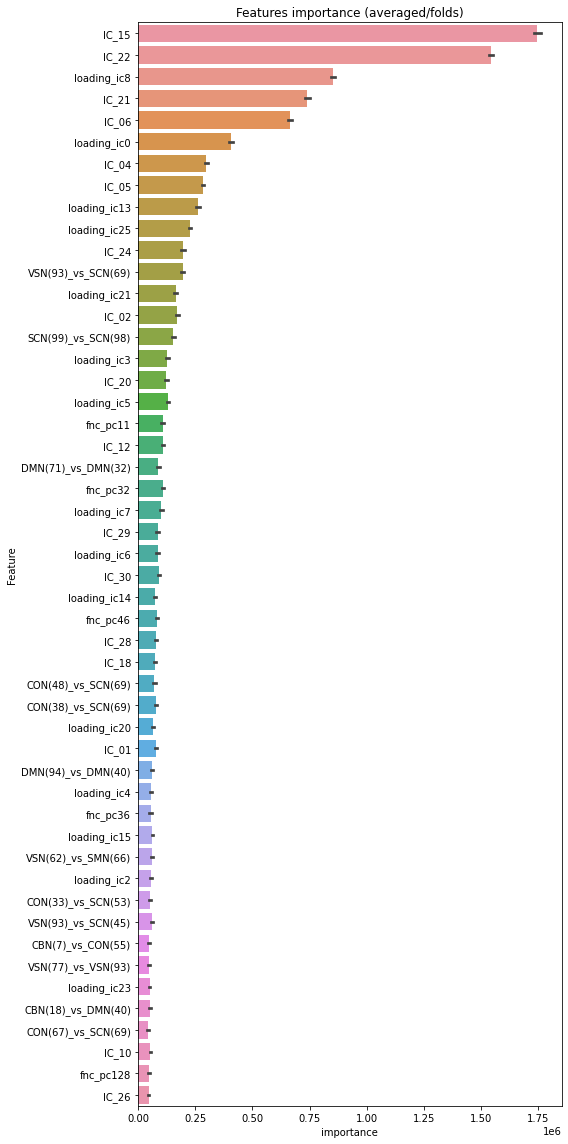

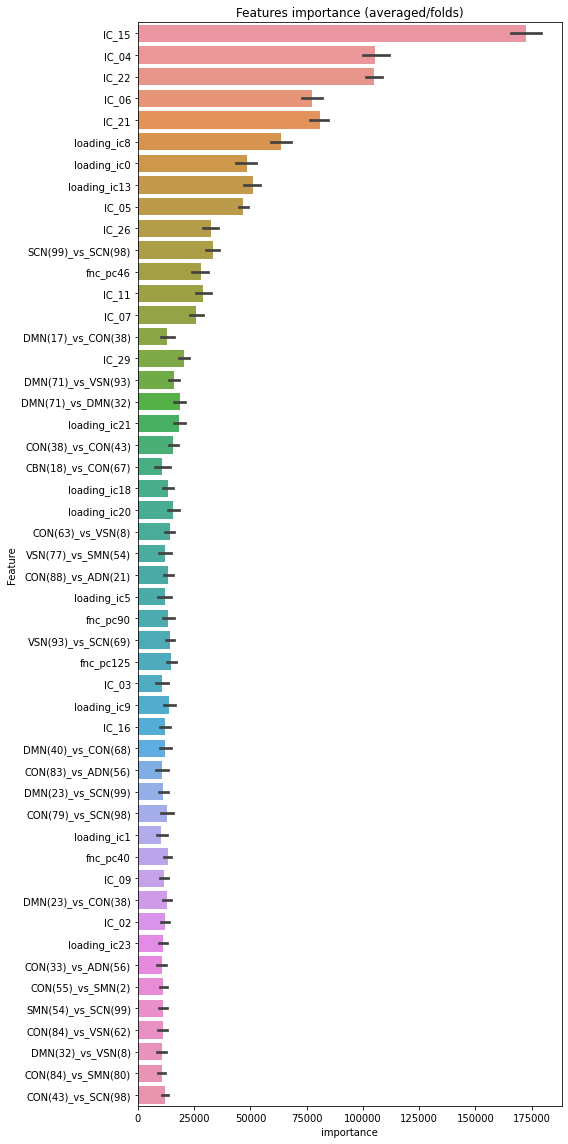

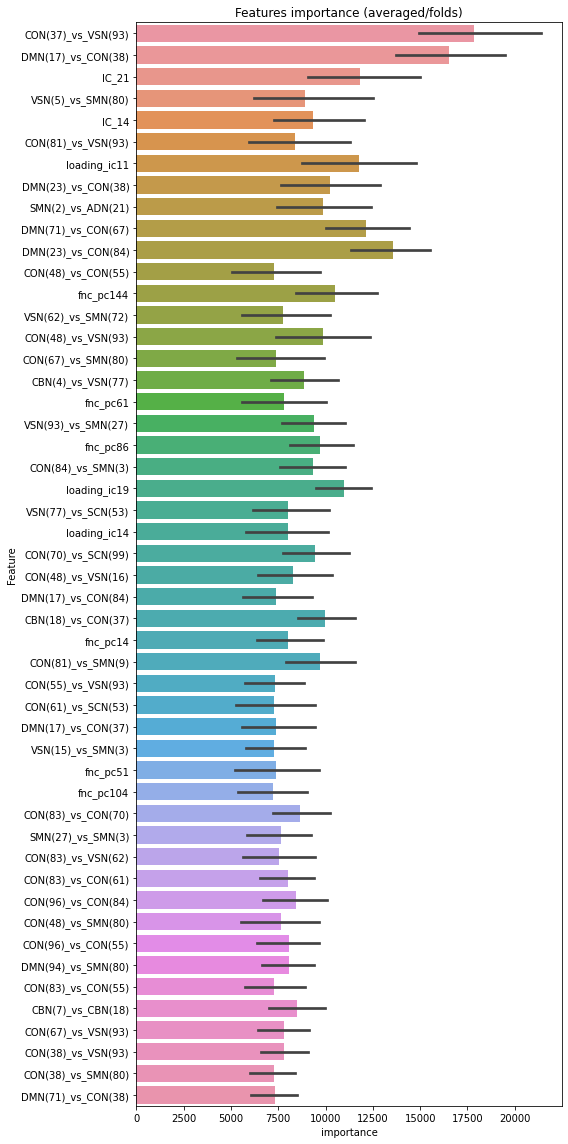

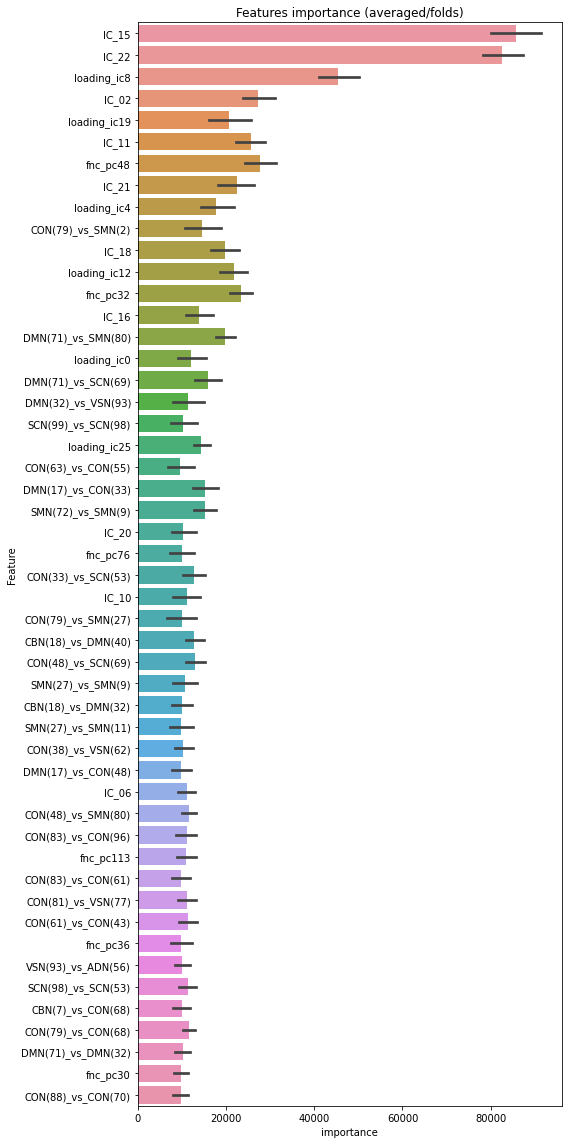

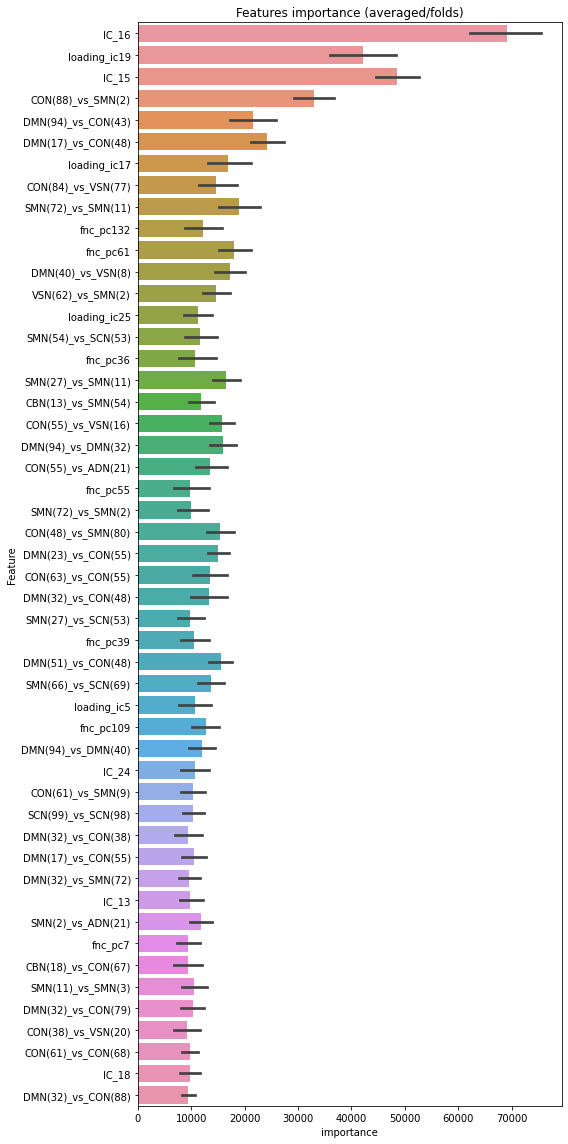

In [25]:
layer1_pred_train_targets_lgb = {}
layer1_pred_test_targets_lgb = {}

pred_train_targets_lgb_dfs = {}
pred_test_targets_lgb_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    
    train_df = train[train[target].notnull()]
    test_df = test
    
    use_idx = train_df.index
    
    train_x = train_df.drop([ID]+TARGET_COLS, axis=1)
    train_y = train_df[target]
    test_x = test_df.drop(ID, axis=1)
    #ss.fit(train_x_2)
    #train_x = ss.transform(train_x)
    #train_x = pd.DataFrame(train_x)
    
    #test_x = ss.transform(test_x)
    #test_x = pd.DataFrame(test_x)
    
    train_y = train_df[target]
    
    print("-----{}-----".format(target))
    #train_x, train_y, test_x, target_name, param
    pred_train, preds_test, score_cv, fi = predict_cv_lgb(train_x=train_x,
                                                          train_y=train_y,
                                                          test_x=test_x,
                                                          target_name=target,
                                                          param=lgb_param)
    show_feature_importance(fi, target)
    overal_score += w*score_cv
    layer1_pred_train_targets_lgb[target] = pred_train
    layer1_pred_test_targets_lgb[target] = preds_test
    
    pred_train_targets_lgb_dfs[target] = pd.Series(pred_train, name="pre_lgb_PCICraw_{}".format(target), index=use_idx)
    pred_train_targets_lgb_dfs[target] = pd.merge(train['Id'],
                                                  pred_train_targets_lgb_dfs[target],
                                                  left_index=True,
                                                  right_index=True)
    pred_test_targets_lgb_dfs[target] = pd.Series(preds_test, name="pre_lgb_PCICraw_{}".format(target))
    pred_test_targets_lgb_dfs[target] = pd.concat([test['Id'], pred_test_targets_lgb_dfs[target]], axis=1)
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

In [ ]:
N_FOLD:5
-----age-----
age_score:0.14700111
age_mae:7.354451609859484
age_rmse:9.317636462961504
-----domain1_var1-----
domain1_var1_score:0.15196461
domain1_var1_mae:7.822831536052648
domain1_var1_rmse:9.755431461591984
-----domain1_var2-----
domain1_var2_score:0.15157942
domain1_var2_mae:8.97954761666281
domain1_var2_rmse:11.37754696187342
-----domain2_var1-----
domain2_var1_score:0.18321671
domain2_var1_mae:8.668318085305518
domain2_var1_rmse:10.944875247555299
-----domain2_var2-----
domain2_var2_score:0.17724289
domain2_var2_mae:9.198720430743872
domain2_var2_rmse:11.730396671833388
--------------------------------------------
Overal score: 0.16030097

In [ ]:
-----age-----
age_score:0.14757656
age_mae:7.383152943924243
age_rmse:9.364733546069733
-----domain1_var1-----
domain1_var1_score:0.15186356
domain1_var1_mae:7.817631282354443
domain1_var1_rmse:9.749862894519833
-----domain1_var2-----
domain1_var2_score:0.1516539
domain1_var2_mae:8.98395596652827
domain1_var2_rmse:11.3820081905469
-----domain2_var1-----
domain2_var1_score:0.1832475
domain2_var1_mae:8.669800346789618
domain2_var1_rmse:10.945619557329753
-----domain2_var2-----
domain2_var2_score:0.17727542
domain2_var2_mae:9.200456433186778
domain2_var2_rmse:11.728454771025685
--------------------------------------------
Overal score: 0.16048003

In [ ]:
Overal score: 0.16054234

# Save Pre result

In [27]:
out_base_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models'

In [28]:
with open (out_base_path+'/1st_layer'+'/lgb_fncPC_and_loadingIC_and_raw/lgb_train.pkl', 'wb') as f:
  pkl.dump(pred_train_targets_lgb_dfs , f)
with open (out_base_path+'/1st_layer'+'/lgb_fncPC_and_loadingIC_and_raw/lgb_test.pkl', 'wb') as f:
  pkl.dump(pred_test_targets_lgb_dfs , f)

# Submission